## Cache

### What is cache
* save commonly/recently used data for fast response
* the data are usually saved in RAM or SSD for fast access
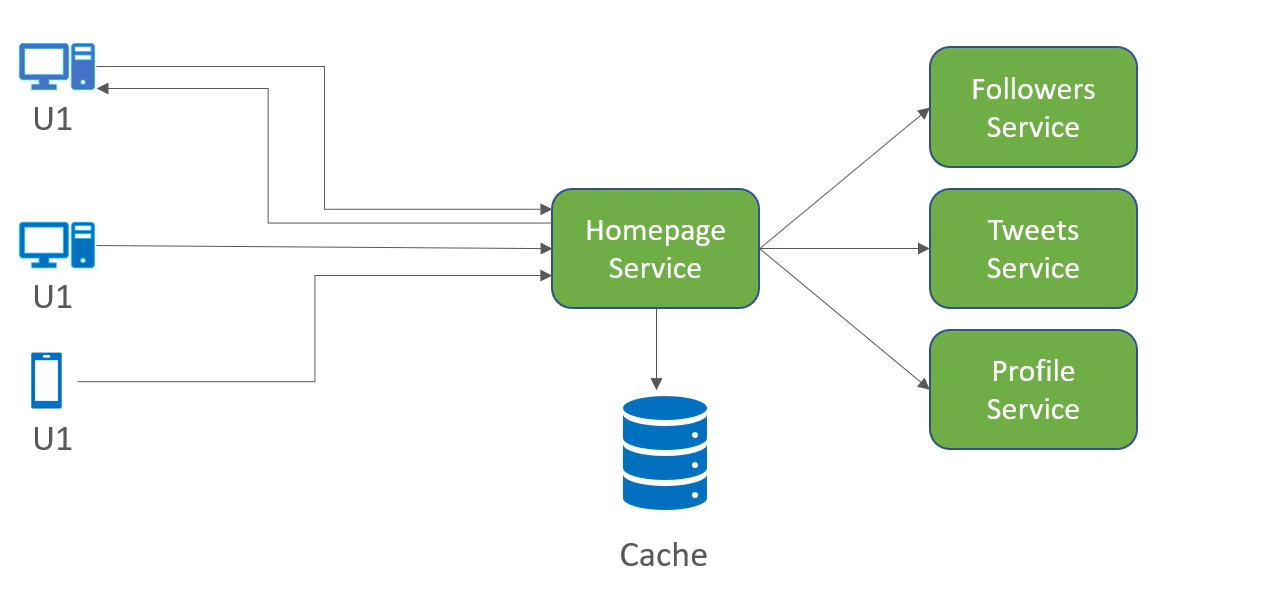

### Computer hardware caches
* L1, L2 and L3 caches
  + L1 is the smallest and fastest cache typically integrated into CPU itself
    + store most frequently accessed data and instructions
    + usually at kBs level
  + L2 is larger but slower than L1 cache 
    + located on the CPU die or on a separate chip
    + at MB level
  + L3 is even larger than L2 and slower than L2
    + shared between multiple CPU cores
* another common hardware cache is translational lookaside buffer (TLB)
  + stores recently used virtual to physical address translations
  + used by CPU to quickly tanslate virtual memory addresses to physical memory addresses and reduces the time needed to access data from memory
  
### Operating system level
* page cache and other file system caches
* page cache is managed by OS and resides in main memory
  + store recently used disk blocks in memory
  + when program requests data from disk, OS can quickly retrieve the data from memory instead of reading from the disk
* Inode cache
  + managed by OS
  + speed up file system operations by reducing the number of acesses required to access files and directories
  
  

### Advantages and disadvantages
* Advantages
  + improve read performance
  + reduce workload of backend serivce (e.g. database)
* Disadvantage
  + increase the complexity of the system
  + consumes more resources (RAM, SSD, and computation resource for management)

### Where to use cache
* Caching can happen in different layers or places of the system
  + Client level, such as browser 
    + Browser downloads and caches static web page (image, HTML, js)
    + The next time when visiting the same web page, no client-server traffic is needed
    + Low latency for web page request
  + Server level
    + Database query cache
      + Cache database results in memory the first time it query an item
      + Much faster response time than database queries
      + Reduce the database query and network traffic and latency
      + A hashed version of the query is used as the cache key 
      + Issues
        + Expiration. Hard to delete a complex query from cache
        + If the database is updated, need to delete all the cached queries affected by the updated cells
    + Cached object
      + After querying several tables and joining the results. We can assemble the result to a customized object, and cache the object.
      + Easy to delete the object when database is updated
      + allows asynchronous operations
      + Use cases of object cache:
        + user sessions (never use the database!)
        + fully rendered blog articles
        + activity streams
        + user<->friend relationships 
    + Between two components
      + Between database and server
      + A separate, centralized cache system accessible to all servers
      + First golden rule for scalability: every server contains exactly the same codebase and does not store any user-related data, like sessions or profile pictures, on local disc or memory
        + Store user session information in redis for better performance
        + After “outsourcing” sessions to an external cache system, all servers have the same codebase. 
        + We can create image files as super-clone to initialize all servers (AWS calls this AMI - Amazon Machine Image) 
        
        


### When to use and not use cache
* cache computation heavy data to reduce latency and CPU utilization
* cache results of network calls from service/database to reduce bandwidth and latency
* use it when we can predict the results will be used in the near future
* don't use it when
  + you need high consistency that can not tolerate stale data such as stock price
  + write heavy but read once data
  + low repetition data that will not be reused frequently
* Eamples of using cache
  + A web app with browser caching static content and server caching database results
    + Reduce network traffic and latency between browser and server
    + Reduce workload on server
    + Reduce network traffic and latency between server and database
    + Reduce workload on database to process queries
  + A computation- intensive task with long latency
      + Cache the computation results
      + When users request the results, directly fetch back instead of compute again

### Update strategy
* problem of caching
  + Two sources of truth: database and cache (redis)
  + If we update database without cache, these two will be out of sync
* solutions for two sources of truth
  + Write through cache: 
    + update both cache and database for write operations (write new records or update old records) at the same time or in the same operation
    + Problem
      + visit both cache and database for every write operation.
      + redundant data. Many cached data will never be used
      + would be more efficient if only access cache for reads if cache has the content, otherwise, need to access database
  + Write back cache
    + Only update cache, and then fetch back results. 
      + Update database asynchronously later in a different process. 
        + for example, we can update database in certain intervals (5 s, 5 mins, or 5 hours)
    + advantages
      + no write penalty
      + reduce the loads on database by using batch mode
    + disadvantage
      + reliability
        + if cache is broken before database updates, you lose all the records stored in cache
        + need to make sure the data are not important, so we can afford to lose data, or the cache never goes down 
      + consistency
        + need to flush cache to remove outdated data timely
  + Cache layer 
    + set up a buffering layer between application and data storage. 
    + Application first tries to retrieve data from cache. Only if it’s not in the cache should it then try to get the data from the main data source
    + This greatly improves the speed. The same applies to write operations
   
  + Cache aside (Redis)
    + app has access to both cache and database
    + app checks cache first, if not find
      + queries database
      + update cache
    + advantages
      + cache only what's needed
    + disadvantages
      + cache misses are expensive
      + data stales
      + implementation compexity (need 2 API calls to work with cache and database)
      
  + read through (ORM)
    + data usually stored in memory
    + app only access cache API
    + for cache miss, cache API queries database, update cache and returns results
    + advantages
      + cache only what's needed
      + transparent to app development
        + developer may not even realize the cache layer
    + disadvantages
      + cache misses are expensive (need to fecth from database and update cache)
      + data staleness
      + reliability issues

### Stale Cache and expiration / eviction strategies
* Stale cache:
  + for systems with multiple servers, each server has its own cache. If a server updates records in its cache, the others will have outdated records in their caches that are out of sync, which we call stale cache
* Solution to stale cache
  + use a single, central cache, such as redis, as the single source of truth. All servers will hit this central cache for write/read
* Stale cache strategies
  + In interview, we need to clarify which features can tolerate stale cache and which can not by asking which features we care the most and need the most updated version
    + for example, youtube visit count may be OK to be out of sync
* two types of strategies to remove stale data from cache
  + time based
    + evict the entries after the pre-set TTL (Time To Live)
  + size based 
    + we only store certain number of entries. When new entry comes, we   evict some old entries to save new entries 
      + FIFO (Fist In First Out)
      + LFU (Least Frequently Used)
        + every key has a counter that is incremented once in a while
        + when there is a cache hit, the counter of the key is set to zero while other keys keep increasing
        + when there is a cache miss, key with the largest count value is evicted
        + elements with often access are kept forever
        + have overhead to keep the count for each entry
        + has less false cache eviction than LRU
      + LRU (Least Recently Used)
        + maintained as a linked list. Newly visited elements are attached to the tail, and the head element is deleted
        + very efficient without requiring too much memory and CPU
        + disadvantages
          + suffers from false cache eviction
            + when a lot of new keys are requested at once, it may evict some popular keys
      + LFRU least frequently and recently used
    
### Metrics
* size of cache
  + increasing size reduce the performance and increase the cost, which is not good
  + cache should have small size with relavant data 
* latency
  + can improve latency compared to not using it
* cache hit rate (opposite to cache missing rate)
  + ratio of how many time you get data from cache to the total number of requests you send to cache
  + small size will decrease latency but decrease the cache hit rate and decrease the overall performance of the system
  + apply appropriate eviction strategy to make sure we cache the most relavant data and improve the cache hit rate
  
### Redis
* in-memory, key-value store
* limited by RAM: biggest servers are around 500 GB RAM
* supports 100 K + requests/second on a single node
* supports string, list, set, hash and others as values
* no support for JSON and nested data types
* keys support TTL (after TTL, GET queries returns nothing)
* support disk persistence to write data to disk,and recover data from disk when node crashes
  + still will have data loss, since persist every second, may lose data within one second
* used as a remote service, which introduces latency and need to consider the situation when you can't connect to remote server  